<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr14/Practice14_meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import numpy as np 
import time
import pickle


from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_moons


from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm.notebook import tqdm, trange

import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.utils.data.sampler import Sampler

In [ ]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, SVHN
from torchvision.utils import make_grid

In [ ]:
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import argparse
import time
import typing

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!pip install higher

In [ ]:
import higher

##  [MAML](http://proceedings.mlr.press/v70/finn17a.html)(Model-Agnostic Meta-Learning)

MAML is an optimization-based meta-learning algorithm, which means that it tries to adjust the standard optimization procedure to a few-shot setting. The idea of MAML is relatively simple: given a model, support, and query set during training, we optimize the model for $m$ steps on the support set and evaluate the gradients of the query loss with respect to the original model's parameters. For the same model, we do it for a few different support-query sets and accumulate the gradients. This results in learning a model that provides a good initialization for being quickly adapted to the training tasks. If we denote the model parameters with $\theta$, we can visualize the procedure as follows 

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/MAML_figure.svg?raw=1" width="300px"></center>

The full algorithm of MAML is therefore as follows. At each training step, we sample a batch of tasks, i.e., a batch of support-query set pairs. For each task $\mathcal{T}_i$, we optimize a model $f_{\theta}$ on the support set via SGD, and denote this model as $f_{\theta_i'}$. We refer to this optimization as _inner loop_. Using this new model, we calculate the gradients of the original parameters, $\theta$, with respect to the query loss on $f_{\theta_i'}$. These gradients are accumulated over all tasks and used to update $\theta$. This is called _outer loop_ since we iterate over tasks. The full MAML algorithm is summarized below

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/MAML_algorithm.svg?raw=1" width="400px"></center>

To obtain gradients for the initial parameters $\theta$ from the optimized model $f_{\theta_i'}$, we actually need second-order gradients, i.e. gradients of gradients, as the support set gradients depend on $\theta$ as well. This makes MAML computationally expensive, especially when using multiple inner loop steps.

# data

In [ ]:
train_set = MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
# Merging original training and test set
all_images = np.concatenate([train_set.data, test_set.data], axis=0)
all_targets = np.concatenate([train_set.targets, test_set.targets], axis=0)

In [ ]:
class ImageDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, i):
        img, target = self.imgs[i], self.targets[i]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [ ]:
train_classes, test_classes = torch.arange(8), torch.arange(8, 10)

In [ ]:
def dataset_from_labels(imgs, targets, class_set, transform=None):
    targets = torch.Tensor(targets)
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask], 
                        img_transform=transform)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

train_set = dataset_from_labels(all_images, all_targets, train_classes, img_transform=transform)
test_set = dataset_from_labels(all_images, all_targets, test_classes, img_transform=transform)

In [ ]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=True, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot 

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {} 
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = len(self.indices_per_class[c]) // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if self.shuffle:
            self.shuffle_data()
        else:
            self.class_list = self.classes * min(self.batches_per_class.values())

    def shuffle_data(self):
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        random.shuffle(self.class_list)

    def __iter__(self):
        if self.shuffle:
            self.shuffle_data()

        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [ ]:
batch_size = 8
N_WAY = 2
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=batch_size * N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True))

In [ ]:
test_data_loader = data.DataLoader(test_set,
                                   batch_sampler=FewShotBatchSampler(test_set.targets,
                                                                      include_query=False,
                                                                      N_way=2,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=False))

In [ ]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

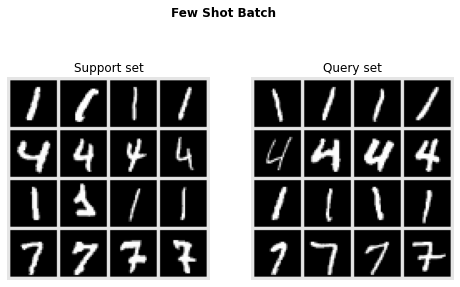

In [ ]:
imgs, targets = next(iter(train_data_loader))
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

# model

In [ ]:
class MamlNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
                                nn.Conv2d(1, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(64, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(64, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Flatten(),
                                nn.Linear(64, 1)
                                )
    
    def forward(self, x):
        return self.net(x)
    
    def test(self, dataloader):
        y_pred = []
        y_true = []

        for (x, y) in dataloader:
            res = self.net(x.to(device).float())
            y_pred.append(res.squeeze().detach().cpu().numpy())
            y_true.append(y.squeeze().cpu().numpy())

        y_pred = np.hstack(y_pred)
        y_true = np.hstack(y_true)

        return y_pred, y_true

In [ ]:
model = MamlNet().to(device)

# maml

In [ ]:
import higher

In [ ]:
def train(data_loader, net, device, meta_opt, epoch):
    net.train()

    for (x, y) in data_loader:
        start_time = time.time()
        # Sample a batch of support and query images and labels.
        x_spt, x_qry, y_spt, y_qry = split_batch(x, y)
        

        # reshape into batch of tasks
        x_spt = x_spt.reshape(-1, 8, 1, 28, 28)
        x_qry = x_qry.reshape(-1, 8, 1, 28, 28)
        y_spt = y_spt.reshape(-1, 8)
        y_qry = y_qry.reshape(-1, 8)

        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        # Initialize the inner optimizer to adapt the parameters to
        # the support set.
        n_inner_iter = 3
        
        inner_opt = torch.optim.SGD(net.parameters(), lr=1e-2)

        meta_opt.zero_grad()
        for i in range(task_num):
            with higher.innerloop_ctx(net, inner_opt, copy_initial_weights=False) as (fnet, diffopt):
                if len(torch.unique(y_spt[i])) == 1:
                    continue
                labels_spt = (y_spt[i] == y_spt[i][0]).float().view(-1, 1)
                labels_qry = (y_qry[i] == y_spt[i][0]).float().view(-1, 1)

                for _ in range(n_inner_iter):
                    spt_logits = fnet(x_spt[i].to(device))

                    spt_loss = F.binary_cross_entropy_with_logits(spt_logits, labels_spt.to(device))
                    diffopt.step(spt_loss)

               
                qry_logits = fnet(x_qry[i].to(device))
                qry_loss = F.binary_cross_entropy_with_logits(qry_logits, labels_qry.to(device))
                
                qry_loss.backward()

        meta_opt.step()

In [ ]:
meta_opt = optim.Adam(model.parameters(), lr=1e-3)

for epoch in trange(20):
    train(train_data_loader, model, device, meta_opt, epoch)

  0%|          | 0/20 [00:00<?, ?it/s]

# testing

In [ ]:
def test(net, test_data_loader, test_data, n_inner_iter=10, samples=1):
    accs = []
    full_loader = data.DataLoader(test_data, batch_size=200, shuffle=False)
    for i, (x, y) in enumerate(tqdm(test_data_loader)):
        if i >= samples:
            break
        net_c = deepcopy(net)

       
        opt = torch.optim.SGD(net_c.parameters(), lr=1e-2)

        

        for j in range(n_inner_iter):
        
            logits = net_c(x.to(device)).squeeze()
            if j == 0:
                with torch.no_grad():
                    score0 = logits[y == test_classes[0]].mean()
                    score1 = logits[y == test_classes[1]].mean()
                    pos = test_classes[0] if score0 > score1 else test_classes[0]
                    labels = (y == pos).float()
            loss = F.binary_cross_entropy_with_logits(logits, labels.to(device))

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        net_c.eval()
        y_pred, y_true = net_c.test(full_loader)
        y_true =  (y_true == pos.numpy()).astype(int)
        accs.append(acc(y_true, y_pred > 0))
    return accs

In [ ]:
res = test(model, test_data_loader, test_set, 10, 10)

In [ ]:
f"{np.mean(res):.4f}"

'0.8126'

# baseline

In [ ]:
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Sequential(
                                nn.Conv2d(1, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(64, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(64, 64, 3),
                                nn.BatchNorm2d(64, momentum=1, affine=True),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(2, 2),
                                nn.Flatten()
                                )
        
        self.tail = nn.Sequential(nn.Linear(64, 8))
        
        self.tail2 = nn.Sequential(nn.Linear(64, 1))

        self.pretrained = True
    
    def forward(self, x):
        x = self.head(x)
        if self.pretrained:
            return self.tail(x)
        return self.tail2(x)


    def pretrain(self, dataset, num_epochs=20):
        data_loader = data.DataLoader(dataset,
                                      batch_size=200,
                                      shuffle=True)
        
        opt = optim.Adam(self.parameters(), lr=1e-3)

        for epoch in trange(num_epochs):
            for (x, y) in data_loader:
                pred = self(x.to(device))
                loss = F.cross_entropy(pred, y.to(device).long())
                opt.zero_grad()
                loss.backward()
                opt.step()
    
    def finetune(self, test_data_loader, test_data, n_inner_iter=1, samples=1):
        self.pretrained = False
        accs = []
        full_loader = data.DataLoader(test_data, batch_size=200, shuffle=False)
        for i, (x, y) in enumerate(tqdm(test_data_loader)):
            if i >= samples:
                break
            net_c = deepcopy(self)

        
            opt = torch.optim.SGD(net_c.parameters(), lr=1e-2)


            for j in range(n_inner_iter):
                logits = net_c(x.to(device)).squeeze()
                if j == 0:
                    with torch.no_grad():
                        score0 = logits[y == test_classes[0]].mean()
                        score1 = logits[y == test_classes[1]].mean()
                        pos = test_classes[0] if score0 > score1 else test_classes[0]
                        labels = (y == pos).float()
                    
                loss = F.binary_cross_entropy_with_logits(logits, labels.to(device))

                opt.zero_grad()
                loss.backward()
                opt.step()
            
            net_c.eval()
            y_pred, y_true = net_c.test(full_loader)
            y_true =  (y_true == pos.numpy()).astype(int)
            accs.append(acc(y_true, y_pred > 0))
        return accs


    
    def test(self, dataloader):
        y_pred = []
        y_true = []

        for (x, y) in dataloader:
            res = self(x.to(device).float())
            y_pred.append(res.squeeze().detach().cpu().numpy())
            y_true.append(y.squeeze().cpu().numpy())

        y_pred = np.hstack(y_pred)
        y_true = np.hstack(y_true)

        return y_pred, y_true

In [ ]:
basemodel = BaseNet().to(device)
basemodel.pretrain(train_set)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
res_base = basemodel.finetune(test_data_loader, test_set, 10, 10)

In [ ]:
f"{np.mean(res_base):.4f}"

'0.6342'